In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

path = "./Qwen2.5-VL-3B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
from transformers import AutoProcessor
from vllm import LLM, SamplingParams
from qwen_vl_utils import process_vision_info

path = "Qwen/Qwen2.5-VL-3B-Instruct"

target_answer = """Describe the visible content of this image shortly, objectively and factually **as a single, continuous paragraph of prose.** Focus on the main subjects or elements present. Note their key visual characteristics (e.g., color, shape, texture if prominent) and their spatial arrangement or relationship to one another. If any actions or interactions are depicted, describe them simply.

**Crucially, do NOT use any structural formatting:**
*   Avoid bullet points, numbered lists, or any list-like structures.
*   Do not use introductory phrases that signal a list or structure (e.g., "Key elements include:", "The characteristics are:", "Present are:").
*   Do not use section headings or labels within the description.

Integrate all descriptive details smoothly into the narrative paragraph. Stick strictly to what is visually present. Avoid interpretations, assumptions, artistic analysis, or personal opinions. Make the description short.
"""

llm = LLM(
    model=path,
    limit_mm_per_prompt={"image": 1, "video": 0},
    gpu_memory_utilization=0.4
)
sampling_params = SamplingParams(
    temperature=0,
    max_tokens=512,
)

INFO 04-23 11:23:51 [__init__.py:239] Automatically detected platform cuda.
INFO 04-23 11:23:58 [config.py:689] This model supports multiple tasks: {'reward', 'score', 'generate', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 04-23 11:23:58 [config.py:1901] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 04-23 11:23:59 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='Qwen/Qwen2.5-VL-3B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-VL-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=128000, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observabilit

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 04-23 11:24:03 [gpu_model_runner.py:1276] Starting to load model Qwen/Qwen2.5-VL-3B-Instruct...
INFO 04-23 11:24:03 [config.py:3466] cudagraph sizes specified by model runner [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512] is overridden by config [512, 384, 256, 128, 4, 2, 1, 392, 264, 136, 8, 400, 272, 144, 16, 408, 280, 152, 24, 416, 288, 160, 32, 424, 296, 168, 40, 432, 304, 176, 48, 440, 312, 184, 56, 448, 320, 192, 64, 456, 328, 200, 72, 464, 336, 208, 80, 472, 344, 216, 88, 120, 480, 352, 248, 224, 96, 488, 504, 360, 232, 104, 496, 368, 240, 112, 376]
WARNING 04-23 11:24:03 [topk_topp_sampler.py:69] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 04-23 11:24:06 [loader.py:458] Loading weights took 1.52 seconds
INFO 04-23 11:24:06 [gpu_model_runner.py:1291] Model loading took 7.1557 GiB and 2.268216 seconds
INFO 04-23 11:24:07 [gpu_model_runner.py:1560] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 1 image items of the maximum feature size.
INFO 04-23 11:24:16 [backends.py:416] Using cache directory: /root/.cache/vllm/torch_compile_cache/03d49285be/rank_0_0 for vLLM's torch.compile
INFO 04-23 11:24:16 [backends.py:426] Dynamo bytecode transform time: 6.71 s
INFO 04-23 11:24:17 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 04-23 11:24:23 [monitor.py:33] torch.compile takes 6.71 s in total
INFO 04-23 11:24:23 [kv_cache_utils.py:634] GPU KV cache size: 510,912 tokens
INFO 04-23 11:24:23 [kv_cache_utils.py:637] Maximum concurrency for 128,000 tokens per request: 3.99x
INFO 04-23 11:24:42 [gpu_model_runner.py:1626] Graph capturing finished in 19 secs, t

In [2]:
rewrite_template = """**Objective:** Generate an image description as a single, continuous paragraph. The core content of this description **MUST** be derived *exclusively* from the facts mentioned in the 'Human Transcription'. This content should then be expressed using the writing style (vocabulary, sentence structure, objective tone) demonstrated in the 'Target Model Style Example'.

**Inputs:**

1.  **Target Model Style Example (Style Reference ONLY):**
    ```
    {model_description}
    ```
    *(This text demonstrates HOW to phrase things objectively and descriptively. Its specific content (e.g., flowers, colors, light streaks) is COMPLETELY IRRELEVANT and MUST BE IGNORED unless explicitly mentioned in the Human Transcription.)*

2.  **Human Transcription (The ONLY source of factual CONTENT):**
    ```
    {human_transcription}
    ```
    *(This dictates WHAT needs to be described. Ignore conversational style/opinions.)*

**Task - Follow these steps STRICTLY:**

1.  **Step 1: Extract Facts from Human Transcription.** Identify the key factual elements (objects, attributes, location, actions, setting like 'sunset') mentioned in the `Human Transcription`. List these facts internally. *Example: If Human says "These are flowers against the backdrop of a sunset," the core facts are [flowers, sunset backdrop].*

2.  **Step 2: Build Output based *ONLY* on Extracted Facts.** Construct sentences describing ONLY the facts identified in Step 1.

3.  **Step 3: Apply Target Style to the Constructed Sentences.** Rephrase the sentences from Step 2 using vocabulary, sentence structure, and objective tone similar to the `Target Model Style Example`. Ensure the phrasing is sophisticated and descriptive, fitting the style.

4.  **Step 4: Combine into a Single Paragraph.** Merge the stylistically adapted sentences into a single, coherent paragraph.

**Examples of Correct Transformation:**

*   **Example 1:**
    *   Human Transcription: "I like blue, bright blue, blue."
    *   Correct Output: "The image features a serene landscape dominated by a tranquil blue sky, which serves as a calming backdrop for the scene. The sky is adorned with soft, wispy clouds that gently drift across the horizon, adding a sense of depth and tranquility to the composition. Below the sky, the ground is covered in lush green grass, dotted with delicate white flowers that add a touch of purity and serenity to the landscape. The overall effect is one of peace and natural beauty, evoking a sense of calm and tranquility."

*   **Example 2:**
    *   Human Transcription: "I see flowers or clovers of various shades against a red background."
    *   Correct Output: "The image showcases a vivid display of flowers or clovers in various shades against a striking red background. The flowers, rendered in hues of blue, green, pink, and purple, appear to be floating or moving, creating an impression of a lively, almost ethereal garden. The overall effect is one of movement and energy, as if the flowers are dancing in a field of light."

*   **Example 3:**
    *   Human Transcription: "I also see a strange set of characters."
    *   Correct Output: "Beyond other potential visual elements within the composition, attention is drawn to the inclusion of a set of characters possessing a distinctly strange or unconventional appearance. These forms, characterized by their peculiar design, introduce an element of the unusual or unexpected into the visual field, contributing uniquely to the overall scene's perceived nature."


**CRITICAL RULES:**

*   **Human Facts are Paramount:** If a detail (object, color, interpretation like 'dynamic') exists in the `Target Model Style Example` but NOT in the `Human Transcription`, it **MUST NOT** appear in the output.
*   **Content Matches Human Input:** The final description's subject matter must directly reflect what the human mentioned. If the human mentioned a 'sunset', the output MUST describe a sunset backdrop, using the target style. If the human only mentioned 'blue', the output MUST focus solely on 'blue'.
*   **No Lists/Headings:** The final output must be a single paragraph.
*   **Conciseness Reflects Input:** If the `Human Transcription` is very brief, the resulting description should also be brief, simply elevating the style of the few facts mentioned.

**Output:**

Provide only the synthesized image description as a single paragraph, built exclusively from human-provided facts and expressed in the target model's style.
"""

In [3]:
from datasets import Dataset, load_dataset


data = load_dataset("Archistrax/dried_heatmaps")
data

DatasetDict({
    train: Dataset({
        features: ['human_id', 'image', 'suffix', 'heatmap', 'transcribation', 'audio_file', 'asc_file'],
        num_rows: 833
    })
})

In [4]:
import sys

sys.path.append("/workspace/")

In [5]:
from src.common.templates import messages_template

processor = AutoProcessor.from_pretrained(path)

def make_answer_vllm(messages):

    prompts = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    
    inputs = []
    for idx, prompt in enumerate(prompts):
        mm_data = {}
        sample = {"prompt": prompt}
        if image_inputs:
            sample["multi_modal_data"] = {"image": image_inputs[idx]}
        inputs.append(sample)
    outputs = llm.generate(inputs, sampling_params=sampling_params)
    return [out.outputs[0].text for out in outputs]

def update_dataset(features):

    messages = []
    images = features["image"]
    transcribations = features["transcribation"]
    
    for image in images:
        prompts = messages_template(image, "")[:1]
        prompts[0]['content'][0]['image'] = "." + prompts[0]['content'][0]['image']
        prompts[0]['content'][1]['text'] = target_answer
        messages.append(prompts)

    results = make_answer_vllm(messages)

    messages = []
    for image, result, transcribation in zip(images, results, transcribations):
        prompts = messages_template(image, "")[:1]
        prompts[0]['content'][1]['text'] = rewrite_template.format(
            model_description=result, human_transcription=transcribation
        )
        prompts[0]['content'] = prompts[0]['content'][1:]
        messages.append(prompts)

    updated_transcribations = make_answer_vllm(messages)
    
    return {"model_description": results, "upd_transcribation": updated_transcribations}



processed_dataset = data["train"].map(update_dataset, batched=True, batch_size=50, num_proc=1)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Parameter 'function'=<function update_dataset at 0x7fbc205c6f80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/50 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/33 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

Processed prompts:   0%|                             | 0/33 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, ou…

In [8]:
from dotenv import load_dotenv

load_dotenv("../.env")

processed_dataset.push_to_hub("Archistrax/processed_transcribations")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Archistrax/processed_transcribations/commit/b021b1fe7e196c653d2011a7a8ab8c5e1934eec6', commit_message='Upload dataset', commit_description='', oid='b021b1fe7e196c653d2011a7a8ab8c5e1934eec6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Archistrax/processed_transcribations', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Archistrax/processed_transcribations'), pr_revision=None, pr_num=None)

In [9]:
heatmaps = processed_dataset["heatmap"]

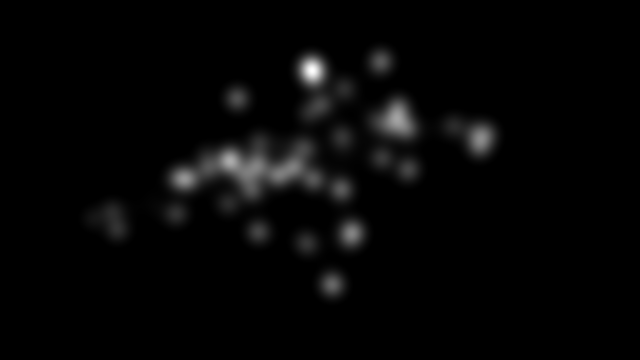

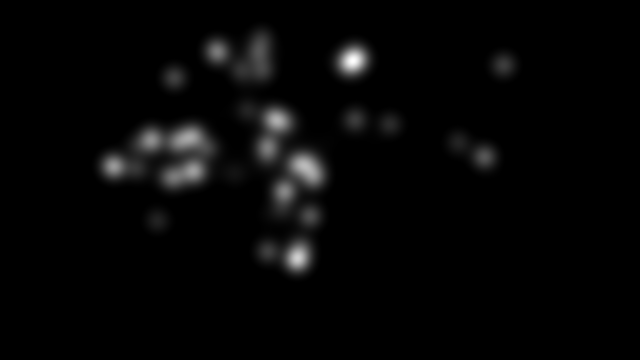

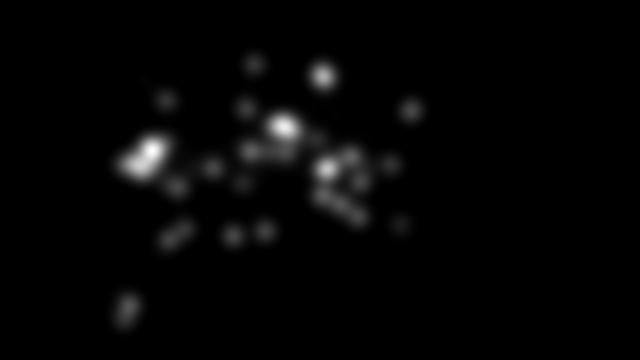

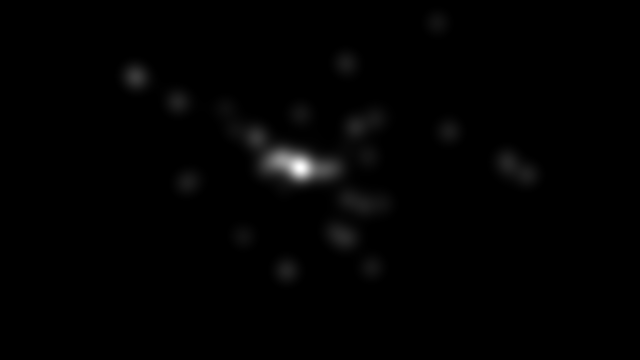

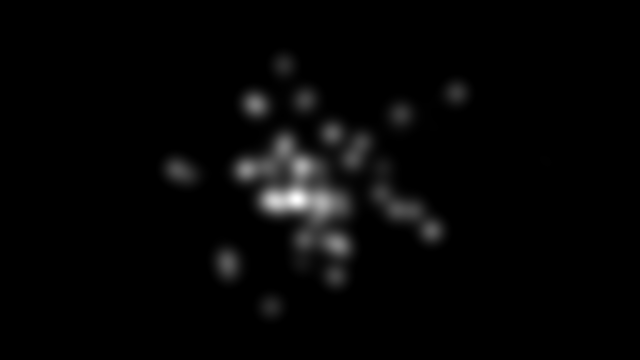

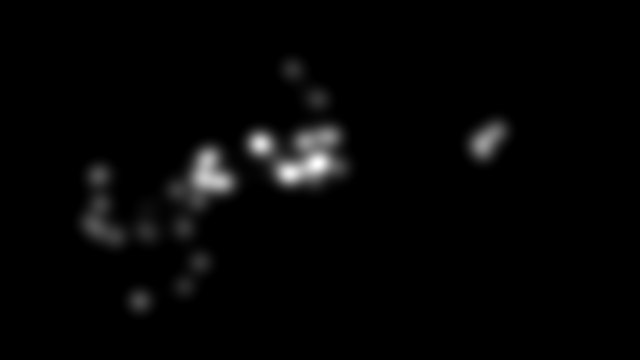

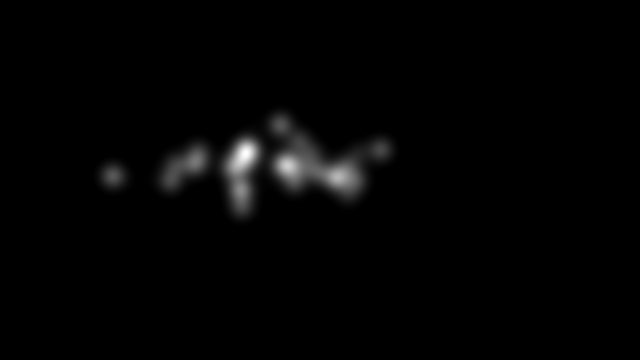

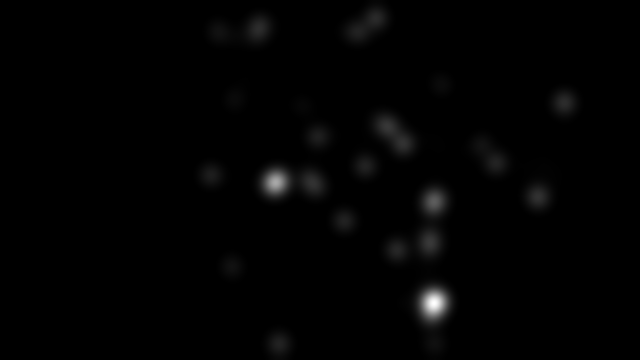

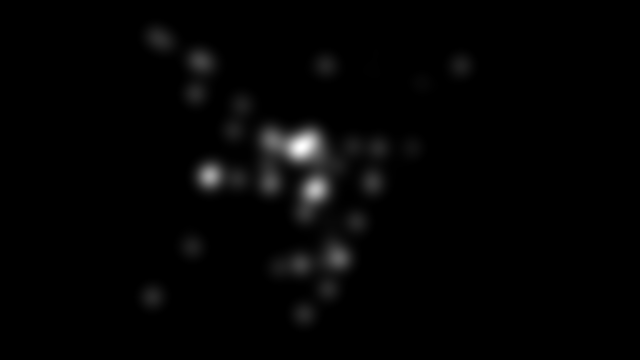

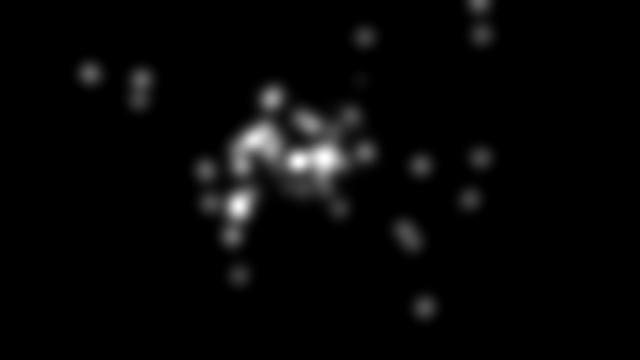

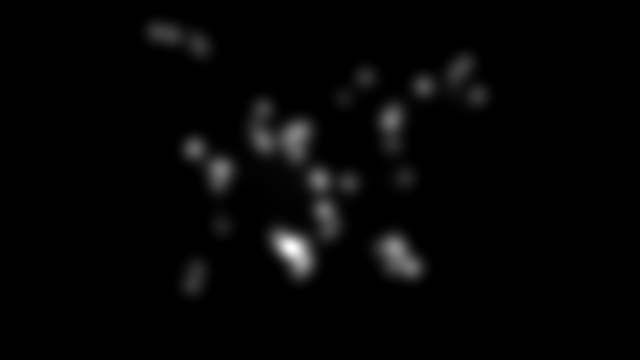

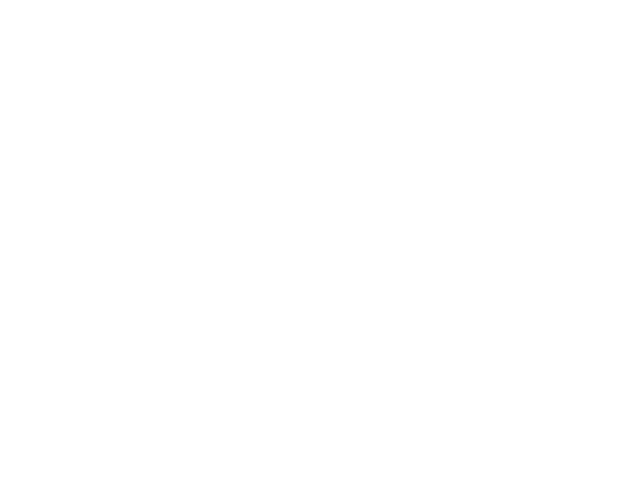

In [20]:
from IPython.display import display
import numpy as np


WHITE_CHECK_STD_THRESHOLD = 3.0  # Макс. стандартное отклонение для "однотонности"
WHITE_CHECK_MEAN_THRESHOLD = 250.0 # Мин. среднее значение (0-255) для "белого"


def is_image_mostly_white(pil_image, std_threshold=WHITE_CHECK_STD_THRESHOLD, mean_threshold=WHITE_CHECK_MEAN_THRESHOLD):
    """
    Проверяет, является ли PIL изображение преимущественно белым.
    Конвертирует в градации серого, считает std и mean.
    Возвращает True, если std < std_threshold И mean > mean_threshold.
    """
    if pil_image is None:
        return False
    try:
        gray_image = pil_image.convert('L')
        img_array = np.array(gray_image)
        std_dev = np.std(img_array)
        mean_val = np.mean(img_array)

        if std_dev < std_threshold and mean_val > mean_threshold:
            return True
        else:
            return False
    except Exception as e:
        return False # Считаем, что не белое, если проверка не удалась

for heat in heatmaps[:20]:
    display(heat)
    if is_image_mostly_white(heat):
        break

In [23]:
filtered_dataset = processed_dataset.filter(lambda x: not is_image_mostly_white(x["heatmap"]))
filtered_dataset

Dataset({
    features: ['human_id', 'image', 'suffix', 'heatmap', 'transcribation', 'audio_file', 'asc_file', 'model_description', 'upd_transcribation'],
    num_rows: 778
})

In [24]:
filtered_dataset.push_to_hub("Archistrax/processed_transcribations")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Archistrax/processed_transcribations/commit/2096583cb0b7481aaa27a25526a4efc2764fc159', commit_message='Upload dataset', commit_description='', oid='2096583cb0b7481aaa27a25526a4efc2764fc159', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Archistrax/processed_transcribations', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Archistrax/processed_transcribations'), pr_revision=None, pr_num=None)

In [25]:
filtered_dataset

Dataset({
    features: ['human_id', 'image', 'suffix', 'heatmap', 'transcribation', 'audio_file', 'asc_file', 'model_description', 'upd_transcribation'],
    num_rows: 778
})

In [26]:
filtered_dataset["transcribation"] = filtered_dataset["upd_transcribation"]

TypeError: 'Dataset' object does not support item assignment

In [5]:
from src.common.templates import messages_template

# default processor
processor = AutoProcessor.from_pretrained(path)
target_answer = """Describe the visible content of this image shortly, objectively and factually **as a single, continuous paragraph of prose.** Focus on the main subjects or elements present. Note their key visual characteristics (e.g., color, shape, texture if prominent) and their spatial arrangement or relationship to one another. If any actions or interactions are depicted, describe them simply.

**Crucially, do NOT use any structural formatting:**
*   Avoid bullet points, numbered lists, or any list-like structures.
*   Do not use introductory phrases that signal a list or structure (e.g., "Key elements include:", "The characteristics are:", "Present are:").
*   Do not use section headings or labels within the description.

Integrate all descriptive details smoothly into the narrative paragraph. Stick strictly to what is visually present. Avoid interpretations, assumptions, artistic analysis, or personal opinions. Make the description short.
"""

def make_answer(messages):
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    
    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

messages = messages_template(data[0]["image"], "")[:1]
messages[0]['content'][1]['text'] = target_answer
make_answer(messages)

'The image features an abstract composition with vibrant colors and dynamic shapes. Dominating the background is a deep red hue, creating a striking contrast against the colorful elements in the foreground. Various flowers and leaves, rendered in shades of blue, green, pink, and purple, are scattered throughout the scene. These elements appear to be floating or moving, giving the impression of a lively, almost ethereal garden. The overall effect is one of movement and energy, as if the flowers are dancing in a field of light.'

In [8]:
one = data.filter(lambda x: x if x["image"] == 'abstraction_4.jpg' else None)

In [9]:
for item in one["transcribation"][-5:]:

    print(f"Human description: {item}\n")
    messages = messages_template(data[0]["image"], "")[:1]
    
    messages[0]['content'][1]['text'] = rewrite_template.format(
        model_description="The image features an abstract composition with vibrant colors and dynamic shapes. Dominating the background is a deep red hue, creating a striking contrast against the colorful elements in the foreground. Various flowers and leaves, rendered in shades of blue, green, pink, and purple, are scattered throughout the scene. These elements appear to be floating or moving, giving the impression of a lively, almost ethereal garden. The overall effect is one of movement and energy, as if the flowers are dancing in a field of light.",
        human_transcription=item
    )
    messages[0]['content'] = messages[0]['content'][1:]
    print(f"Model description: {make_answer(messages)}\n\n")

Human description: The image of the flowers is intensely red.

Model description: The image features a vibrant display of flowers in various shades of blue, green, pink, and purple, rendered against a deep red backdrop. These elements appear to be floating or moving, creating an impression of a lively, almost ethereal garden. The overall effect is one of movement and energy, as if the flowers are dancing in a field of light.


Human description: This is a painting depicting flowers being blown by the wind in a field.

Model description: The image depicts a painting of flowers being blown by the wind in a field. Dominating the background is a deep red hue, creating a striking contrast against the colorful elements in the foreground. Various flowers and leaves, rendered in shades of blue, green, pink, and purple, are scattered throughout the scene. These elements appear to be floating or moving, giving the impression of a lively, almost ethereal garden. The overall effect is one of movem

In [39]:
one["transcribation"]

['The painting depicts some kind of flowers in an abstract form against a red background, with the flowers appearing multicolored.',
 'A painting of flowers on a red background, featuring flowers in green, blue, and white. The flowers at the bottom are smaller and more numerous than those at the top.',
 'I like blue, bright blue, blue.',
 'These are flowers against the backdrop of a sunset.',
 'A red background with butterflies fluttering everywhere.',
 'The painting of flowers on a red background is probably done in acrylics.',
 'It looks like a painting by a modern artist, with a bunch of colorful flowers shining against a red background.',
 'I think this is a sketch of a flower field against a sunset.',
 'I see flowers or clovers of various shades against a red background.',
 'I also see a strange set of characters.',
 'This is a psychedelic image of a flower against a red background.',
 "I think it's not really my taste in art at all.",
 'A multitude of abstract, translucent flower